In [22]:
import kan
import kan.utils as ku
import torch
import torch.nn as nn
import numpy as np
from libraries import utils
from libraries import magnetization
import numpy.random as npr
import qutip as qt
import sympy
import random

In [2]:
def J1J2_hamiltonian(N, j1, j2):
    id = qt.qeye(2)
    x = qt.sigmax()
    y = qt.sigmay()
    z = qt.sigmaz()
    sxi = []; syi = []; szi = []
    for i in range(N):
        sxi.append(qt.tensor([id] * i + [x] + [id] * (N - i - 1)))
        syi.append(qt.tensor([id] * i + [y] + [id] * (N - i - 1)))
        szi.append(qt.tensor([id] * i + [z] + [id] * (N - i - 1)))
    sis = [sxi, syi, szi]
    J1_term = j1 * (sum(sis[coord][i] * sis[coord][i + 1] for coord in range(len(sis)) for i in range(N - 1)) + sum(sis[coord][N - 1] * sis[coord][0] for coord in range(len(sis))))
    J2_term = j2 * (sum(sis[coord][i] * sis[coord][i + 2] for coord in range(len(sis)) for i in range(N - 2)) + sum(sis[coord][N - 2] * sis[coord][0] for coord in range(len(sis))) + sum(sis[coord][N - 1] * sis[coord][1] for coord in range(len(sis))))
    return J1_term + J2_term

def count_half_magnetization(state): 
    """
    Counts number of 1s in binary representation of some integer
    With integer encoding of state such that 1 in binary representation 
    is spin down and 0 is spin up. Returns number of spin downs.
    """
    if state == 0: return 0
    return sum((state >> n) & 1 for n in range(0, int(np.log2(state)) + 1, 2))

In [3]:
N=10
input = utils.generate_input_torch(N)
labels = torch.tensor([-1 + 2 * (count_half_magnetization(i) % 2) for i in range(2 ** N)]).reshape((-1, 1))

In [4]:
dataset = {'train_input': input, 'train_label': labels, 'test_input': input, 'test_label': labels}
kan_model = kan.KAN(width = [N, N, 1, 1])
kan_model(dataset['train_input']);
# kan_model.plot()

checkpoint directory created: ./model
saving model version 0.0


In [5]:
kan_model.fix_symbolic(2, 0, 0, lambda x : torch.tanh(x))
# kan_model.fix_symbolic(2, 0, 0, lambda x : sympy.tanh(x))

saving model version 0.1


In [6]:
kan_model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);

| train_loss: 8.86e-03 | test_loss: 8.86e-03 | reg: 8.38e+00 | : 100%|█| 20/20 [00:24<00:00,  1.20s/

saving model version 0.2


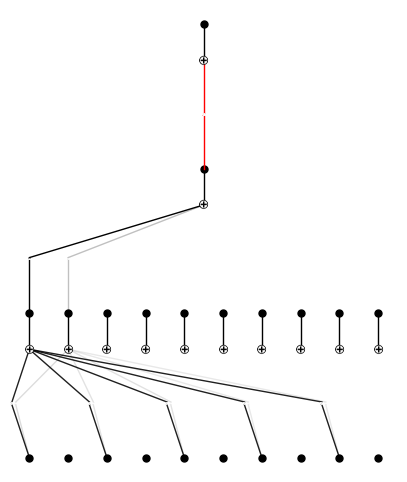

In [7]:
kan_model.plot()

saving model version 0.3


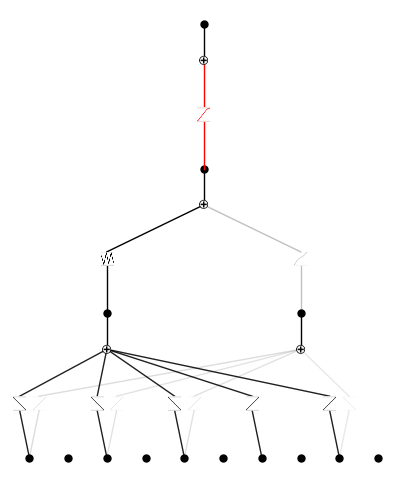

In [8]:
kan_model = kan_model.prune()
kan_model.plot()

In [9]:
kan_model.suggest_symbolic(1, 0, 0);

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        0    0.000000  0.000014           0                0    0.000003
1      sin    0.989073 -6.514589           2                2    0.297082
2      cos    0.989073 -6.514581           2                2    0.297084
3        x    0.008519 -0.012328           1                1    0.797534
4      tan    0.993266 -7.212279           3                3    0.957544


In [10]:
kan_model.suggest_symbolic(1, 1, 0);

  function  fitting r2   r2 loss  complexity  complexity loss  total loss
0        x    0.957975 -4.572266           1                1   -0.114453
1        0    0.000000  0.000014           0                0    0.000003
2     sqrt    0.983636 -5.932430           2                2    0.413514
3    x^0.5    0.983636 -5.932430           2                2    0.413514
4      log    0.979954 -5.639818           2                2    0.472036


In [11]:
kan_model.fix_symbolic(1, 0, 0, 'cos')
for i in range(0, N, 2):
    kan_model.fix_symbolic(0, i, 0, 'x')
# kan_model.auto_symbolic(r2_threshold=0.9)

r2 is 0.9890725612640381
saving model version 0.4
r2 is 1.000001072883606
saving model version 0.5
r2 is 1.0000011920928955
saving model version 0.6
r2 is 1.0000011920928955
saving model version 0.7
r2 is 1.0000009536743164
saving model version 0.8
r2 is 1.0000009536743164
saving model version 0.9


In [12]:
kan_model.fit(dataset, opt = 'LBFGS', steps=50);

| train_loss: 4.79e-05 | test_loss: 4.79e-05 | reg: 1.43e+00 | : 100%|█| 50/50 [00:09<00:00,  5.13it

saving model version 0.10


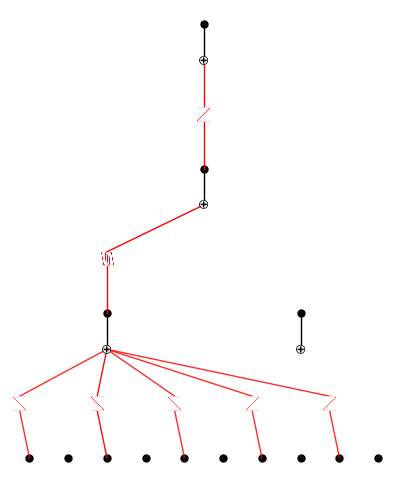

In [13]:
kan_model.plot()

saving model version 0.11


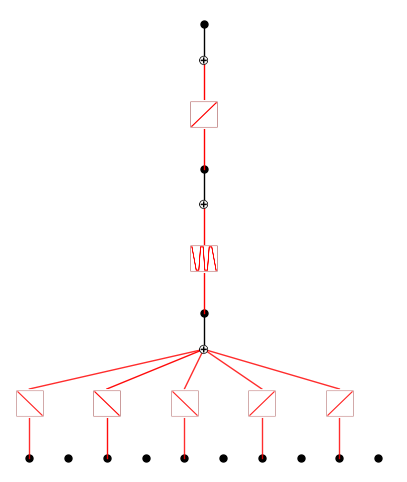

In [14]:
kan_model.prune().plot()

In [15]:
kan_model = kan_model.prune()

saving model version 0.11


In [16]:
kan_model.auto_symbolic()

skipping (0,0,0) since already symbolic
fixing (0,1,0) with 0
skipping (0,2,0) since already symbolic
fixing (0,3,0) with 0
skipping (0,4,0) since already symbolic
fixing (0,5,0) with 0
skipping (0,6,0) since already symbolic
fixing (0,7,0) with 0
skipping (0,8,0) since already symbolic
fixing (0,9,0) with 0
skipping (1,0,0) since already symbolic
skipping (2,0,0) since already symbolic
saving model version 0.12


In [17]:
def symbolic_formula(self, var=None, normalizer=None, output_normalizer = None):
    '''
    get symbolic formula

    Args:
    -----
        var : None or a list of sympy expression
            input variables
        normalizer : [mean, std]
        output_normalizer : [mean, std]
        
    Returns:
    --------
        None

    Example
    -------
    >>> from kan import *
    >>> model = KAN(width=[2,1,1], grid=5, k=3, noise_scale=0.0, seed=0)
    >>> f = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]])+x[:,[1]]**2)
    >>> dataset = create_dataset(f, n_var=3)
    >>> model.fit(dataset, opt='LBFGS', steps=20, lamb=0.001);
    >>> model.auto_symbolic()
    >>> model.symbolic_formula()[0][0]
    '''
    
    symbolic_acts = []
    symbolic_acts_premult = []
    x = []

    def ex_round(ex1, n_digit):
        ex2 = ex1
        for a in sympy.preorder_traversal(ex1):
            if isinstance(a, sympy.Float):
                ex2 = ex2.subs(a, round(a, n_digit))
        return ex2

    # define variables
    if var == None:
        for ii in range(1, self.width[0][0] + 1):
            exec(f"x{ii} = sympy.Symbol('x_{ii}')")
            exec(f"x.append(x{ii})")
    elif isinstance(var[0], sympy.Expr):
        x = var
    else:
        x = [sympy.symbols(var_) for var_ in var]

    x0 = x

    if normalizer != None:
        mean = normalizer[0]
        std = normalizer[1]
        x = [(x[i] - mean[i]) / std[i] for i in range(len(x))]

    symbolic_acts.append(x)

    for l in range(len(self.width_in) - 1):
        num_sum = self.width[l + 1][0]
        num_mult = self.width[l + 1][1]
        y = []
        for j in range(self.width_out[l + 1]):
            yj = 0.
            for i in range(self.width_in[l]):
                a, b, c, d = self.symbolic_fun[l].affine[j, i]
                sympy_fun = self.symbolic_fun[l].funs_sympy[j][i]
                try:
                    yj += c * sympy_fun(a * x[i] + b) + d
                except:
                    yj += c * sympy.tanh(a * x[i] + b) + d
                    print('make sure all activations need to be converted to symbolic formulas first!')
                    # return
            yj = self.subnode_scale[l][j] * yj + self.subnode_bias[l][j]
            y.append(yj)
                
        symbolic_acts_premult.append(y)
            
        mult = []
        for k in range(num_mult):
            if isinstance(self.mult_arity, int):
                mult_arity = self.mult_arity
            else:
                mult_arity = self.mult_arity[l+1][k]
            for i in range(mult_arity-1):
                if i == 0:
                    mult_k = y[num_sum+2*k] * y[num_sum+2*k+1]
                else:
                    mult_k = mult_k * y[num_sum+2*k+i+1]
            mult.append(mult_k)
            
        y = y[:num_sum] + mult
        
        for j in range(self.width_in[l+1]):
            y[j] = self.node_scale[l][j] * y[j] + self.node_bias[l][j]
        
        x = y
        symbolic_acts.append(x)

    if output_normalizer != None:
        output_layer = symbolic_acts[-1]
        means = output_normalizer[0]
        stds = output_normalizer[1]

        assert len(output_layer) == len(means), 'output_normalizer does not match the output layer'
        assert len(output_layer) == len(stds), 'output_normalizer does not match the output layer'
        
        output_layer = [(output_layer[i] * stds[i] + means[i]) for i in range(len(output_layer))]
        symbolic_acts[-1] = output_layer


    self.symbolic_acts = [[symbolic_acts[l][i] for i in range(len(symbolic_acts[l]))] for l in range(len(symbolic_acts))]
    self.symbolic_acts_premult = [[symbolic_acts_premult[l][i] for i in range(len(symbolic_acts_premult[l]))] for l in range(len(symbolic_acts_premult))]

    out_dim = len(symbolic_acts[-1])
    #return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0
    return [symbolic_acts[-1][i] for i in range(len(symbolic_acts[-1]))], x0

In [18]:
symbolic_formula(kan_model)

make sure all activations need to be converted to symbolic formulas first!


([0.00781285390257835 - 1.01169145107269*tanh(4.58312031395053*cos(3.14130334488269*x_1 + 5.01144648145817*x_3 + 3.14139581438527*x_5 - 3.14115238186119*x_7 - 3.14190113194438*x_9 - 0.934711615658917) + 0.494367401528137)],
 [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10])

In [19]:
ku.ex_round(symbolic_formula(kan_model)[0][0], 10)

make sure all activations need to be converted to symbolic formulas first!


0.0078128539 - 1.0116914511*tanh(4.583120314*cos(3.1413033449*x_1 + 5.0114464815*x_3 + 3.1413958144*x_5 - 3.1411523819*x_7 - 3.1419011319*x_9 - 0.9347116157) + 0.4943674015)

In [20]:
kan_model(input)

tensor([[-1.0006],
        [ 0.9962],
        [-1.0006],
        ...,
        [ 0.9963],
        [-1.0006],
        [ 0.9963]], grad_fn=<AddBackward0>)

In [21]:
labels

tensor([[-1],
        [ 1],
        [-1],
        ...,
        [ 1],
        [-1],
        [ 1]])

In [23]:
num_samples = 256
samples = [random.getrandbits(N) for _ in range(num_samples)]
sampled_input = utils.generate_input_samples(N, samples)
sampled_labels = torch.tensor([1 - 2 * (count_half_magnetization(i) % 2) for i in samples]).reshape((-1, 1))
print(sampled_input.shape, sampled_labels.shape)

torch.Size([256, 10]) torch.Size([256, 1])


In [56]:
sampled_dataset = {'train_input': sampled_input, 'train_label': sampled_labels, 'test_input': sampled_input, 'test_label': sampled_labels}
sampling_kan = kan.KAN(width = [N, N, 1, 1])
sampling_kan(sampled_dataset['train_input']);

checkpoint directory created: ./model
saving model version 0.0


In [57]:
sampling_kan.fix_symbolic(2, 0, 0, lambda x : torch.tanh(x));

saving model version 0.1


In [ ]:
sampling_kan.fit(sampled_dataset, opt='LBFGS', steps=20, lamb=0.01); # this seems to work much better with the greater lambda val

| train_loss: 1.24e-02 | test_loss: 1.24e-02 | reg: 4.58e+00 | : 100%|█| 20/20 [00:13<00:00,  1.47it

saving model version 0.2


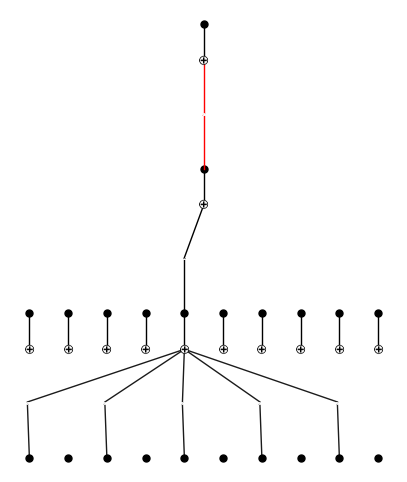

In [59]:
sampling_kan.plot()

saving model version 0.3


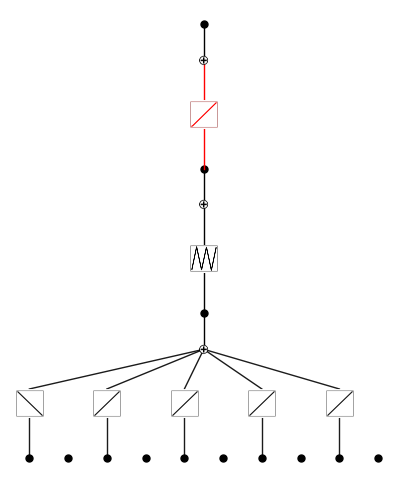

In [60]:
sampling_kan = sampling_kan.prune()
sampling_kan.plot()

  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000001 -16.716706           1                1  -13.173365
1    x^0.5    1.000001 -16.792769           2                2  -13.034215
2     sqrt    1.000001 -16.792769           2                2  -13.034215
3      x^2    1.000001 -16.773374           2                2  -13.018699
4      exp    1.000001 -16.773374           2                2  -13.018699


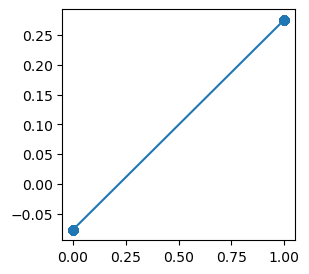

In [66]:
layer = 0
node1 = 4; node2 = 0
sampling_kan.get_fun(layer, node1, node2);
sampling_kan.suggest_symbolic(layer, node1, node2, weight_simple=0.2);

In [67]:
sampling_kan.auto_symbolic(weight_simple=0.2, r2_threshold=0.9);

fixing (0,0,0) with x, r2=1.0000007152557373, c=1
skipping (0,1,0) since already symbolic
fixing (0,2,0) with x, r2=1.0000008344650269, c=1
fixing (0,3,0) with 0
fixing (0,4,0) with x, r2=1.0000007152557373, c=1
fixing (0,5,0) with 0
fixing (0,6,0) with x, r2=1.0000007152557373, c=1
fixing (0,7,0) with 0
fixing (0,8,0) with x, r2=1.0000008344650269, c=1
fixing (0,9,0) with 0
fixing (1,0,0) with cos, r2=0.9998117089271545, c=2
skipping (2,0,0) since already symbolic
saving model version 0.4


In [68]:
sampling_kan.fit(dataset, opt='LBFGS', steps=50);

| train_loss: 6.08e-07 | test_loss: 6.08e-07 | reg: 0.00e+00 | : 100%|█| 50/50 [00:05<00:00,  9.53it

saving model version 0.5


In [70]:
ku.ex_round(symbolic_formula(sampling_kan)[0][0], 4)

make sure all activations need to be converted to symbolic formulas first!


0.1925 - 2.0198*tanh(0.7483*cos(3.1416*x_1 - 3.1416*x_3 - 3.1416*x_5 + 3.1416*x_7 + 4.6286*x_9 - 7.0267) + 0.1274)